Supplementary data and data processing for

# Fracture toughness of mixed-mode anticracks in highly porous materials

**Valentin Adam**<sup>1,2</sup>, **Bastian Bergfeld**<sup>2</sup>, **Philipp Weißgraeber**<sup>3</sup>, **Alec van Herwijnen**<sup>2</sup> & **Philipp L. Rosendahl**<sup>1</sup>

<sup>1</sup>Center of Snow and Avalanche Mechanics, Technical University of Darmstadt, Germany.<br>
<sup>2</sup>Department, WSL Institute for Snow and Avalanche Research SLF, Davos, Switzerland.<br>
<sup>3</sup>Faculty of Mechanical Engineering and Marine Technology, University of Rostock, Germany.

---
## CONTENTS

1. [Preamble](#1.-PREAMBLE)<br>
2. [Data](#2.-DATA)<br>
2.1. [Import test data and legacy data](#2.1.-Import-test-data-and-legacy-data)<br>
2.2. [Compute auxiliary quantities](#2.2-compute-auxiliary-quantities)<br>
3. [Energy release rates](#3.-ENERGY-RELEASE-RATES)<br>
3.1. [Calculation of energy release rates](#3.1-Calculate-energy-release-rates-with-error-propagation)<br>
3.2. [Plot critical cut length](#3.2-plot-critical-cut-length)<br>
3.3. [Plot fraction of mode II energy release rate](#3.3-plot-fraction-of-mode-II-energy-release-rate)<br>
4. [Orthogonal distance regression](#4.-ORTHOGONAL-DISTANCE-REGRESSION)<br>
4.1. [Fit interaction laws to experimental data](#4.1-Fit-interaction-laws-to-experimental-data)<br>
4.2. [Plot interaction laws](#4.2-Plot-interaction-laws)<br>
5. [Total energy release rate](#5.-TOTAL-ENERGY-RELEASE-RATE)<br>
5.1. [Plot total energy release rate with best fit](#5.1-Plot-total-energy-release-rate-with-best-fit)<br>
6. [Sensitivity](#6.-SENSITIVITY)<br>
6.1. [Weak-layer elasticity](#6.1-Weak-layer-elasticity)<br>
6.2. [Weak-layer anisotropy](#6.2-Weak-layer-anisotropy)<br>
6.3. [Density parametrization](#6.3-Density-parametrization)<br>

---
## 1. PREAMBLE

In [2]:
# Third-party imports
import pickle as pkl
import numpy as np
from tqdm import tqdm

# Project imports
import energy as nrg
import regression as reg
import visualization as vis

# Plot setup
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

---
## 2. DATA

### 2.1. Import test data and legacy data

Load and display raw Mixed-Mode Fracture Test data from  'df_mmft.pkl'.

In [3]:
# Load dataframe
df_mmft = pkl.load(open('df_mmft.pkl','rb'))

# Display data
display(df_mmft[['exp_id', 'datetime', 'bunker', 'slope_incl',
                'rc', 'surface_lineload', 'wl_thickness']])

exp_id   datetime  bunker  slope_incl     rc  surface_lineload  \
0    2022_02_18_1 2022-02-18       1           0  109.0          0.001592   
1   2022_02_18_10 2022-02-18       1         -40  235.0          0.001592   
2   2022_02_18_11 2022-02-18       1         -45  265.0          0.001592   
3   2022_02_18_12 2022-02-18       1         -50  287.5          0.001592   
4   2022_02_18_13 2022-02-18       1         -50  310.0          0.001592   
..            ...        ...     ...         ...    ...               ...   
83   2022_03_10_2 2022-03-10       2         -62  260.0          0.002313   
84   2022_03_10_4 2022-03-10       2         -62  232.5          0.002415   
85   2022_03_10_5 2022-03-10       2         -56  202.5          0.002714   
86   2022_03_10_6 2022-03-10       2         -58  215.0          0.002714   
87   2022_03_10_7 2022-03-10       2         -65  227.5          0.002714   

    wl_thickness  
0            8.5  
1            8.5  
2            8.5  
3            8.5  
4            8.5  
..           ...  
83           8.5  
84           8.5  
85           8.5  
86           8.5  
87           8.5  

[88 rows x 7 columns]

Load literature dataframe

In [7]:
# Load dataframe
df_legacy = pkl.load(open('df_legacy.pkl','rb'))

# Display data
display(df_legacy[['layers_mean', 'slope_incl', 'L', 'h', 'wl_thickness', 'rc']])


layers_mean  slope_incl  \
0    [[121.0, 130.0], [194.0, 25.0], [198.0, 25.0],...        19.0   
1    [[121.0, 130.0], [194.0, 25.0], [198.0, 25.0],...        19.0   
2    [[310.0, 10.0], [310.0, 30.0], [164.0, 70.0], ...        33.0   
3    [[133.0, 5.0], [133.0, 25.0], [133.0, 80.0], [...        25.0   
4    [[185.0, 5.0], [185.0, 45.0], [265.0, 230.0], ...        26.0   
..                                                 ...         ...   
178  [[86.0, 5.0], [89.230769, 65.0], [136.933333, ...         0.0   
179  [[86.0, 5.0], [89.230769, 65.0], [136.933333, ...         0.0   
180  [[342.0, 20.0], [324.75, 40.0], [324.1, 100.0]...         0.0   
181  [[274.0, 3.0], [274.0, 17.0], [274.0, 5.0], [2...        34.0   
182  [[274.0, 3.0], [274.0, 17.0], [274.0, 5.0], [2...        34.0   

              L       h  wl_thickness          rc  
0    2857.49706   425.0          8.76   367.43558  
1    3080.00880   425.0          8.76  1515.76097  
2    1721.88320   542.0          8.76   669.89039  
3    1206.33678   220.0          8.76   154.61333  
4    1942.54095   360.0          8.76   307.80290  
..          ...     ...           ...         ...  
178  2680.46086  1770.0          8.76   581.27413  
179  2503.65248  1680.0          8.76   714.81352  
180  2067.63900  1420.0          8.76   776.40914  
181  2104.92466   450.0          8.76   608.56805  
182  1339.54890   450.0          8.76   662.13047  

[183 rows x 6 columns]

### 2.2 Compute auxiliary quantities

Split data frame into 3 series of measurements according to dates and calculate corresponding mean surface line loads

In [4]:
df_series1 = df_mmft[(df_mmft.datetime <= '2022-03-03')]   # Site A, Feb 18 - Mar 3
df_series2 = df_mmft[(df_mmft.datetime >= '2022-03-07') &  # Site B, Mar 7 - Mar 9
                     (df_mmft.datetime <= '2022-03-09')]
df_series3 = df_mmft[(df_mmft.datetime >= '2022-03-10')]   # Site B, Mar 10

print('Mean surface line loads')
print('Series 1: %3.2f N/m (`N = %i)' % (1e3*df_series1['surface_lineload'].mean(), len(df_series1)))
print('Series 2: %3.2f N/m (N = %i)' % (1e3*df_series2['surface_lineload'].mean(), len(df_series2)))
print('Series 3: %3.2f N/m (N = %i)' % (1e3*df_series3['surface_lineload'].mean(), len(df_series3)))

Mean surface line loads
Series 1: 1.59 N/m (`N = 65)
Series 2: 1.48 N/m (N = 17)
Series 3: 2.53 N/m (N = 6)


---
## 3. ENERGY RELEASE RATES

### 3.1 Calculate energy release rates with error propagation

Calculate energy release rates for all data points respecting the following uncertainties:

| Quantity             | Variable  | Uncertainty                   |
| -------------------- | --------  | ----------------------------- |
| Cut length           | $a$       | $\pm 10$ mm                   |
| Weak-layer thickness | $t$       | $\pm 1$ mm                    |
| Slope angle          | $\varphi$ | $\pm 2^\circ$                 |
| Surface load         | $p$       | $\pm 2.5\% \approx \pm1.5$ kg |

In [5]:
# Complement dataframe with fracture toughnesses
df_err = nrg.complement_df(
    df=df_mmft,        # Dataframe w/o outliers
    Ewl=0.2,            # Young's modulus of the weak layer
    da=10,              # Cut length +/- 10 mm
    dt=1,               # Weak-layer thickness +/- 1 mm
    dphi=2,             # Slope angle +/- 2°
    dp=0.025            # Surface line load (N/mm) +/- 2.5%
)
 
# Display results
display(df_err[['rc', 'slope_incl', 'GIc', 'GIIc',
                'Gc', 'Gii/G', 'surface_lineload']])

# Split dataframe between field sites A and B (bunkers 1 and 2)
dfA = df_err[df_err.bunker == 1]
dfB = df_err[df_err.bunker == 2]

rc   slope_incl            GIc           GIIc           Gc  \
0   109+/-10    0.0+/-2.0    0.89+/-0.17  0.022+/-0.008  0.91+/-0.18   
1   235+/-10  -40.0+/-2.0    0.59+/-0.12  0.305+/-0.034  0.90+/-0.14   
2   265+/-10  -45.0+/-2.0    0.60+/-0.13    0.39+/-0.04  0.99+/-0.15   
3   288+/-10  -50.0+/-2.0    0.46+/-0.11    0.45+/-0.05  0.91+/-0.14   
4   310+/-10  -50.0+/-2.0    0.60+/-0.14    0.51+/-0.05  1.11+/-0.17   
..       ...          ...            ...            ...          ...   
83  260+/-10  -62.0+/-2.0  0.029+/-0.031    0.67+/-0.09  0.70+/-0.10   
84  232+/-10  -62.0+/-2.0    0.12+/-0.07    0.73+/-0.09  0.85+/-0.15   
85  202+/-10  -56.0+/-2.0    0.13+/-0.07    0.71+/-0.09  0.83+/-0.14   
86  215+/-10  -58.0+/-2.0    0.08+/-0.05    0.73+/-0.09  0.82+/-0.13   
87  228+/-10  -65.0+/-2.0  0.006+/-0.013    0.69+/-0.09  0.69+/-0.09   

            Gii/G   surface_lineload  
0   0.024+/-0.006  0.00159+/-0.00004  
1     0.34+/-0.04  0.00159+/-0.00004  
2     0.39+/-0.04  0.00159+/-0.00004  
3     0.49+/-0.05  0.00159+/-0.00004  
4     0.46+/-0.05  0.00159+/-0.00004  
..            ...                ...  
83    0.96+/-0.04  0.00231+/-0.00006  
84    0.86+/-0.07  0.00241+/-0.00006  
85    0.85+/-0.06  0.00271+/-0.00007  
86    0.90+/-0.06  0.00271+/-0.00007  
87  0.992+/-0.019  0.00271+/-0.00007  

[88 rows x 7 columns]

Repeat for legacy dataset

In [6]:
# Complement dataframe with fracture toughnesses
dfL = nrg.complement_df(
    df=df_legacy,       # Dataframe w/o outliers
    Ewl=0.2,            # Young's modulus of the weak layer
    da=10,              # Cut length +/- 10 mm
    dt=1,               # Weak-layer thickness +/- 1 mm
    dphi=2,             # Slope angle +/- 2°
    dp=0.025            # Surface line load (N/mm) +/- 2.5%
)

# Display results
display(dfL[['rc', 'slope_incl', 'GIc', 'GIIc',
             'Gc', 'Gii/G', 'surface_lineload']])

rc  slope_incl            GIc             GIIc             Gc  \
0     367+/-10  19.0+/-2.0  0.296+/-0.022  0.0008+/-0.0006  0.297+/-0.022   
1    1516+/-10  19.0+/-2.0    8.97+/-0.33    0.212+/-0.029    9.18+/-0.33   
2     670+/-10  33.0+/-2.0    1.52+/-0.12    0.017+/-0.007    1.54+/-0.13   
3     155+/-10  25.0+/-2.0  0.062+/-0.008  (0.9+/-3.4)e-05  0.062+/-0.008   
4     308+/-10  26.0+/-2.0  0.247+/-0.019  0.0012+/-0.0008  0.248+/-0.020   
..         ...         ...            ...              ...            ...   
178   581+/-10   0.0+/-2.0      3.7+/-0.5    0.006+/-0.009      3.7+/-0.5   
179   715+/-10   0.0+/-2.0      5.6+/-0.7    0.007+/-0.009      5.6+/-0.7   
180   776+/-10   0.0+/-2.0     13.3+/-1.9    0.002+/-0.006     13.3+/-1.9   
181   609+/-10  34.0+/-2.0    1.00+/-0.07  0.0017+/-0.0019    1.00+/-0.07   
182   662+/-10  34.0+/-2.0    2.94+/-0.34    0.040+/-0.013    2.98+/-0.35   

               Gii/G surface_lineload  
0    0.0026+/-0.0020          0.0+/-0  
1    0.0231+/-0.0033          0.0+/-0  
2      0.011+/-0.004          0.0+/-0  
3    0.0001+/-0.0006          0.0+/-0  
4    0.0049+/-0.0032          0.0+/-0  
..               ...              ...  
178  0.0017+/-0.0025          0.0+/-0  
179  0.0012+/-0.0018          0.0+/-0  
180  0.0001+/-0.0004          0.0+/-0  
181  0.0017+/-0.0019          0.0+/-0  
182  0.0136+/-0.0034          0.0+/-0  

[183 rows x 7 columns]

### 3.2 Plot critical cut length

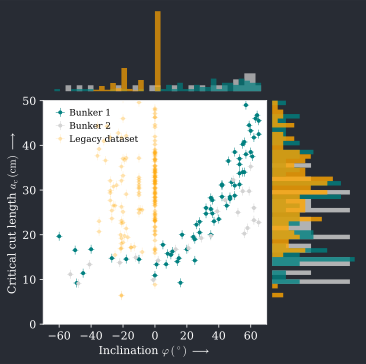

In [7]:
vis.plot_cutlengths(dfA, dfB, dfL)

### 3.3 Plot fraction of mode II energy release rate

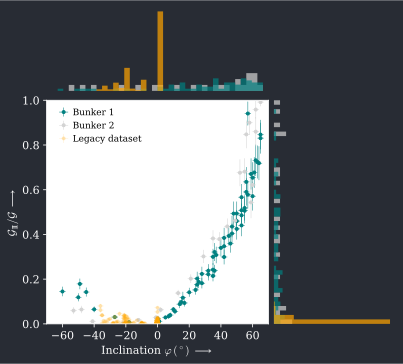

In [8]:
vis.plot_modeIIfraction(dfA, dfB, dfL)

---
## 4. ORTHOGONAL DISTANCE REGRESSION

### 4.1 Fit interaction laws to experimental data

Perform regression for both field sites simultaneously

In [12]:
fit_inv = reg.odr(df_err, exp=100, indi=False, var='C', verbose=True)

Running the following initial guesses for the exponents (n, m):
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.  ]

VARIABLE      VALUE    DESCRIPTION
---------------------------------------------------------------------
GIc           0.557    Mode I fracture toughness
GIIc          0.790    Mode II fracture toughness
n             0.270    Interaction-law exponent
m             0.270    Interaction-law exponent
---------------------------------------------------------------------
chi2          3.321    Reduced chi^2 per DOF (goodness of

In [13]:
fit_inv = reg.odr(df_err, exp=20, indi=True, var='C', verbose=True)

Running the following initial guesses for the exponents (n, m):
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]

VARIABLE      VALUE    DESCRIPTION
---------------------------------------------------------------------
GIc           0.562    Mode I fracture toughness
GIIc          0.790    Mode II fracture toughness
n             0.200    Interaction-law exponent
m             0.450    Interaction-law exponent
---------------------------------------------------------------------
chi2          3.312    Reduced chi^2 per DOF (goodness of fit)
p-value     1.2e-22    p-value (statistically significant if below 0.05)
R2            0.232    R-squared (not valid for nonlinear regression)



In [14]:
fit_bk = reg.odr(df_err, exp=np.linspace(1, 1.5, 101, endpoint=True), indi=False, var='BK', verbose=True)

Running the following initial guesses for the exponents (n, m):
[1.    1.005 1.01  1.015 1.02  1.025 1.03  1.035 1.04  1.045 1.05  1.055
 1.06  1.065 1.07  1.075 1.08  1.085 1.09  1.095 1.1   1.105 1.11  1.115
 1.12  1.125 1.13  1.135 1.14  1.145 1.15  1.155 1.16  1.165 1.17  1.175
 1.18  1.185 1.19  1.195 1.2   1.205 1.21  1.215 1.22  1.225 1.23  1.235
 1.24  1.245 1.25  1.255 1.26  1.265 1.27  1.275 1.28  1.285 1.29  1.295
 1.3   1.305 1.31  1.315 1.32  1.325 1.33  1.335 1.34  1.345 1.35  1.355
 1.36  1.365 1.37  1.375 1.38  1.385 1.39  1.395 1.4   1.405 1.41  1.415
 1.42  1.425 1.43  1.435 1.44  1.445 1.45  1.455 1.46  1.465 1.47  1.475
 1.48  1.485 1.49  1.495 1.5  ]

VARIABLE      VALUE    DESCRIPTION
---------------------------------------------------------------------
GIc           0.593    Mode I fracture toughness
GIIc          1.124    Mode II fracture toughness
n             1.000    Interaction-law exponent
m             1.000    Interaction-law exponent
-------------------

### 4.2 Plot interaction laws

Plot regression results for all data points (bunkers 1+2) with inverse-exponent power-law model and save to file

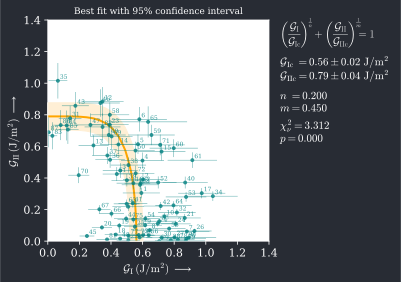

In [16]:
# Plot data (careful: writes vertices of best-fit curve to fit_inv)
vis.plot_interactionlaw(df_err, fit=fit_inv, annotate=True)

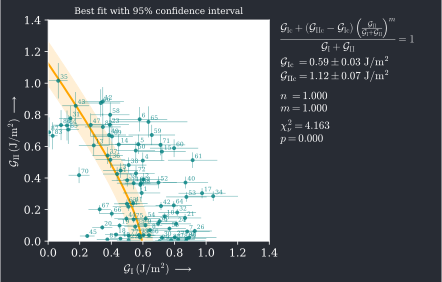

In [17]:
# Plot data (careful: writes vertices of best-fit curve to fit_bk)
vis.plot_interactionlaw(df_err, fit=fit_bk, annotate=True)

---
## 5. TOTAL ENERGY RELEASE RATE

### 5.1 Plot total energy release rate with best fit

Power-law

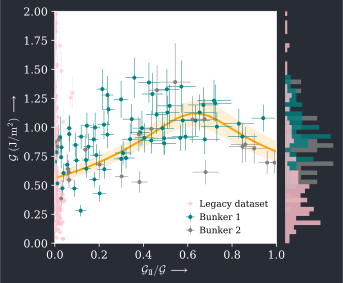

In [18]:
# Plot data (careful: writes vertices of best-fit curve for total ERRs to fit_inv)
vis.plot_totalERR(dfA, dfB, dfL, fit_inv)

Benzeggagh-Kenane

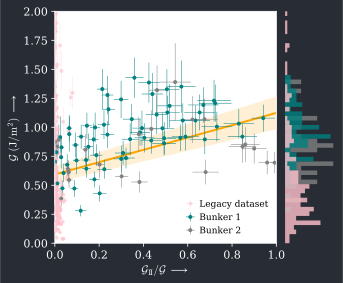

In [19]:
# Plot data (careful: writes vertices of best-fit curve for total ERRs to fit_bk)
vis.plot_totalERR(dfA, dfB, dfL, fit_bk)

---
## 6. SENSITIVITY

### 6.1 Weak-layer elasticity

In [20]:
# Assumptions
Ewl = np.arange(0.05, 1.05, 0.05)       # Youngs moduli of the weak layer
nm = (5, 2)                             # Exponent of the interaction law

# Loop through different assumptions for the weak-layer Young modulus
for Ei in tqdm(Ewl):
    # Compute energy release rates
    dfi = nrg.complement_df(
        df=df_mmft,        # Dataframe w/o outliers
        Ewl=Ei,             # Young's modulus of the weak layer
        da=10,              # Cut length +/- 10 mm
        dt=1,               # Weak-layer thickness +/- 1 mm
        dphi=2,             # Slope angle +/- 2°
        dp=0.025            # Surface line load (N/mm) +/- 2.5%
    )
    # Fit interaction law to data and extract curves
    fiti = vis.curves(reg.odr(dfi, exp=nm, indi=True, print_results=False))
    

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


### 6.2 Weak-layer anisotropy

In [21]:
# Assumptions
nu = np.arange(0.00, 0.525, 0.025)      # Poisson's ratios of the weak layer
nm = (5, 2)                             # Exponent of the interaction law

# Loop through different assumptions for the weak-layer Young modulus
for nui in tqdm(nu):
    # Compute energy release rates
    dfi = nrg.complement_df(
        df=df_mmft,        # Dataframe w/o outliers
        nu=nui,             # Poisson's ratio of the weak layer
        Ewl=0.2,            # Young's modulus of the weak layer
        da=10,              # Cut length +/- 10 mm
        dt=1,               # Weak-layer thickness +/- 1 mm
        dphi=2,             # Slope angle +/- 2°
        dp=0.025            # Surface line load (N/mm) +/- 2.5%
    )
    # Fit interaction law to data and extract curves
    fiti = vis.curves(reg.odr(dfi, exp=nm, indi=True, print_results=False))
    

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


### 6.3 Density parametrization

In [22]:
# Assumptions
C1 = np.arange(3.5, 5.3, 0.3)       # Exponent of the density scaling
nm = (5, 2)                         # Exponent of the interaction law

# Loop through different assumptions for the weak-layer Young modulus
for C1i in tqdm(C1):
    # Compute energy release rates
    dfi = nrg.complement_df(
        df=df_mmft,        # Dataframe w/o outliers
        C1=C1i,             # Exponent of the density scaling
        Ewl=0.2,            # Young's modulus of the weak layer
        da=10,              # Cut length +/- 10 mm
        dt=1,               # Weak-layer thickness +/- 1 mm
        dphi=2,             # Slope angle +/- 2°
        dp=0.025            # Surface line load (N/mm) +/- 2.5%
    )
    # Fit interaction law to data and extract curves
    fiti = vis.curves(reg.odr(dfi, exp=nm, indi=True, print_results=False))

100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
